In [2]:
# For Colocalization Analysis. 

# Data needed: 
# l_path: Path to Leader Track files
#     A path that points to a list of tracked files with names "track-[tr_num].csv"
#     CSV files' track number must match that of file name
#     Must only contain one spot per frame
#     Columns for XYZT: xco, yco, zco, i1, i2, i3, frame #
# f_path: Path to Follower XYZT files
#     The filenames must be "XYZT-[tr_num].csv" with tr_num matching in the leader files
# std_pos_param: window for std position calculations
# shell: number of pixels added to the radius to produce sphere of 'nuclear movement'
# first-frame: number of the first particle position to consider making radius from - i.e., input 2 = 1 in dict
# rad_window: frame number to calculate pos_start over - i.e., (avg of [first_frame, first_frame + rad_window])
# md_cut: cutoff for trajectory distance after particle leaves nucleus defined by miniball + shell
# dist_cut: cutoff for distance to consider a follower and leader 'colocalized', in UM
# d__to_um: for converting pixels to voxels. If (1, 1, 1) corresponds to (0.1037, 0.1037, 0.2612) in um, then values in um for scaling

# Procedure: 
# Setup
#     Create dictionary d
#     Arranging leader & follower CSV's into two pandas dataframes dfL and dfF
#     Combine dfL and dfF into a list with a dictionary dB, store thsoe lists in d
#     New labeled in dL: dx, dy, dz, dist, std_pos_x, dxN, dyN, dzN, correl_A, correl_B, center_dist, marker
#     Arrange list [dL, dF, dB] 
# Calculations
#     Calculate distance traveled over each trajectory, store dx/dy/dz, dist
#     Find std_pos_x 
#     Find normalized trajectories, calculate correlations 
#     Use miniball, md_cut to find when leader leaves nucleus
#     Create dB, a new dictionary to entries with keys of frame # in dL, and list value containing distances of frame leader to all followers
#     Calculate distances between leader and follower for each frame, store in dB
# Visualization
#     Graph distance between leader and closest spot
# Metrics & Histogram

# Notes on columns: 
#     std_pos_x is moving stadard deviation of POSITION between t = k, t = k+std_pos_param
#     correl_A is correlation from -1 to 1; a percent of a traj. at t = k that is in the direction of t = k-1
#     correl_B is correlation without dividing by length from t = k+1
#     center_dist is the distance a particle is from a particular center which will be determined later


In [3]:
# Packages: 

%matplotlib inline
import scipy
from scipy.stats import norm
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import os
from os.path import exists
import path
import miniball
import statistics as st
from scipy.stats import norm

In [61]:
typestring = 'fis1KO_dnm1DN'     # empty, fis1KO_dnm1WT, fis1KO_dnm1DN
dist_cut = 0.311 # in um

In [62]:
# Variables: 

if typestring == 'fis1KO_dnm1DN':
    base_path = '/Users/andrewperun/LusKing/CoLoc_Movies/Atg39-GFP_Dnm1-mCh__fis1KO_dnm1DN'
    l_path = base_path + '/leader/'
    f_path = base_path + '/follower/'
    coloc_list_path = base_path + '/ColocInstances-fis1KOdnm1DN-d2-5.xlsx'
    output_excel_path = base_path + '/TrackData-fis1KOdnm1DN-d2-5.xlsx'
    
    coloc_list_path2 = '/Users/andrewperun/LusKing/CoLoc_Movies/comp_02-05-24/ColocList-fis1KO_dnm1DN.xlsx'
    output_excel_path2 = '/Users/andrewperun/LusKing/CoLoc_Movies/comp_02-05-24/TrackData-fis1KO_dnm1DN.xlsx'
    
elif typestring == 'fis1KO_dnm1WT':
    base_path = '/Users/andrewperun/LusKing/CoLoc_Movies/Atg39-GFP_Dnm1-mCh__fis1KO_dnm1WT'
    l_path = base_path + '/leader/'
    f_path = base_path + '/follower/'
    coloc_list_path = base_path + '/ColocInstances-fis1KOdnm1WT-d2-5.xlsx'
    output_excel_path = base_path + '/TrackData-fis1KOdnm1WT-d2-5.xlsx'
    
    coloc_list_path2 = '/Users/andrewperun/LusKing/CoLoc_Movies/comp_02-05-24/ColocList-fis1KO_dnm1WT.xlsx'
    output_excel_path2 = '/Users/andrewperun/LusKing/CoLoc_Movies/comp_02-05-24/TrackData-fis1KO_dnm1WT.xlsx'

elif typestring == 'empty':
    base_path = '/Users/andrewperun/LusKing/CoLoc_Movies/Atg39-GFP_Dnm1-mCh_evect_2'
    l_path = base_path + '/leader/'
    f_path = base_path + '/follower/'
    coloc_list_path = base_path + '/ColocInstances-emptyVector-d2-5.xlsx'
    output_excel_path = base_path + '/TrackData-emptyVector-d2-5.xlsx'
    
    coloc_list_path2 = '/Users/andrewperun/LusKing/CoLoc_Movies/comp_02-05-24/ColocList-empty.xlsx'
    output_excel_path2 = '/Users/andrewperun/LusKing/CoLoc_Movies/comp_02-05-24/TrackData-empty.xlsx'

    
dx_to_um = 0.1037
dy_to_um = 0.1037
dz_to_um = 0.2612
std_pos_param = 3
shell = 4           
first_frame = 1
rad_window = 4
md_cut = 4.5 # we consider greater than *or equal to* as leaving nucleus

In [63]:
# Functions: 

# Creating dictionary of DFs: 
def create_dictionary(l_path, f_path):
    
    ifExistent = exists(l_path) and exists(f_path)
    if ifExistent == False:
        print("One or more folders are not provided.")
        return 1

    Lead_all = sorted([l_path + f for f in os.listdir(l_path)])
    Foll_all = sorted([f_path + f for f in os.listdir(f_path)])

    LeadFiles = [k for k in Lead_all if 'csv' in k]
    FollFiles = [k for k in Foll_all if 'csv' in k]

    LeadHead = ["xco","yco","zco","i1","i2","i3","frame","tr_num","dx","dy","dz","dxN","dyN","dzN", "dist","std_pos_x","correl_A","correl_B","center_dist","marker","dnm1dist" ]
    FollHead = ["xco","yco","zco","i1","i2","i3","frame"]

    d = {}

    for i in range(len(LeadFiles)):
        dfL = pd.read_csv(LeadFiles[i], names=LeadHead)
        dfF = pd.read_csv(FollFiles[i], names=FollHead, index_col=False)
        dB = {}
        dfList = [dfL, dfF, dB]
        d[i] = dfList
    
    print("Dictionary created with " + str(len(d)) + " entries")
    
    return d

# Miniball: Computing centers and radii
# https://github.com/marmakoide/miniball 
# https://github.com/marmakoide/miniball/blob/master/LICENSE, MIT License
def modify_dictionary_ball(d, rad_window=None, shell=None, first_frame=None):
    
    if rad_window==None or shell==None or first_frame==None:
        print("Insufficient inputs.")
        return 1;
    
    print("Running...")

    center_list = []    # a list of arrays, going to be a list of list of ints
    radius_list = []    # a list of arrays, going to be a lists of ints

    for i in range(len(d)):
    
        small_list = []  # a list, will append position arrays to it
        for j in range(rad_window):
            small_list.append(np.array([d[i][0].at[first_frame + j, 'xco'], d[i][0].at[first_frame + j, 'yco'], d[i][0].at[first_frame + j, 'zco']]))
        coord_arr = np.array(small_list)
    
        C, r2 = miniball.get_bounding_ball(coord_arr)
    
        C = C.tolist()
        C = [float(str(elem)) for elem in C]
    
        center_list.append(C)
        radius_list.append(float(str(r2 ** 0.5)) + shell)

    # Computing distance from the center for those centers in list center_dist   

        for j in range(len(d[i][0])):
        
            d[i][0].at[j, 'center_dist'] = (((d[i][0].at[j, 'xco'] - center_list[i][0]) ** 2) + ((d[i][0].at[j, 'yco'] - center_list[i][1]) ** 2) + ((d[i][0].at[j, 'zco'] - center_list[i][2]) ** 2)) ** 0.5
        
    print("Metrics Produced")
    return d

# Calculating trajectory distance, std_pos, correlations: 
def modify_dictionary_metrics(d, std_pos_param=None):
    
    if std_pos_param == None:
        print("Provide integer std_pos_param.")
        return 1

    for i in range(len(d)):
        d[i][0]['xco'] = d[i][0]['xco'].apply(lambda x: x*dx_to_um)
        d[i][0]['yco'] = d[i][0]['yco'].apply(lambda y: y*dy_to_um)
        d[i][0]['zco'] = d[i][0]['zco'].apply(lambda z: z*dz_to_um)
        
        d[i][1]['xco'] = d[i][1]['xco'].apply(lambda x: x*dx_to_um)
        d[i][1]['yco'] = d[i][1]['yco'].apply(lambda y: y*dy_to_um)
        d[i][1]['zco'] = d[i][1]['zco'].apply(lambda z: z*dz_to_um)
    
    # differentials
        for j in range(0, (len(d[i][0])-1)):
            p = j+1
            d[i][0].at[p, 'dx'] = d[i][0].at[p, 'xco'] - d[i][0].at[j, 'xco'] # dx = xco(j+1) - xco(j)
            d[i][0].at[p, 'dy'] = d[i][0].at[p, 'yco'] - d[i][0].at[j, 'yco'] # dy = yco(j+1) - yco(j)
            d[i][0].at[p, 'dz'] = d[i][0].at[p, 'zco'] - d[i][0].at[j, 'zco'] # dz = zco(j+1) - zco(j)
        
    # distance, normalized
        for k in range(len(d[i][0])):
            d[i][0].at[k, 'dist'] = ((d[i][0].at[k, 'dx'] ** 2) + (d[i][0].at[k, 'dy'] ** 2) + (d[i][0].at[k, 'dz'] ** 2)) ** 0.5 # length of vector using distance formula
            d[i][0].at[k, 'dxN'] = (d[i][0].at[k, 'dx']) / (d[i][0].at[k, 'dist']) # Norm(dx) = dx/len
            d[i][0].at[k, 'dyN'] = (d[i][0].at[k, 'dy']) / (d[i][0].at[k, 'dist']) # Norm(dy) = dy/len
            d[i][0].at[k, 'dzN'] = (d[i][0].at[k, 'dz']) / (d[i][0].at[k, 'dist']) # Norm(dz) = dz/len
    # correlations
        for j in range(0, (len(d[i][0]))-1):
            p = j+1
            d[i][0].at[p, 'correl_A'] = (1/(d[i][0].at[p, 'dist'])) * ( ((d[i][0].at[p, 'dx'])*(d[i][0].at[j, 'dxN'])) + ((d[i][0].at[p, 'dy'])*(d[i][0].at[j, 'dyN'])) + ((d[i][0].at[p, 'dz'])*(d[i][0].at[j, 'dzN'])) )
            d[i][0].at[p, 'correl_B'] = ((d[i][0].at[p, 'dx'])*(d[i][0].at[j, 'dxN'])) + ((d[i][0].at[p, 'dy'])*(d[i][0].at[j, 'dyN'])) + ((d[i][0].at[p, 'dz'])*(d[i][0].at[j, 'dzN']))


        for j in range(std_pos_param-1, (len(d[i][0]))):
        
            sumx = sumy = sumz = 0                   # set accumulator for sum of x positions
        
            for k in range(j-(std_pos_param)+1, j+1):  # taking sum of (1, 2, ... , std_len_param)
                sumx = sumx + d[i][0].at[k, 'xco']
                sumy = sumy + d[i][0].at[k, 'yco']
                sumz = sumz + d[i][0].at[k, 'zco']

            meanx = sumx / std_pos_param              # mean of x position is sum of positions divided by window
            meany = sumy / std_pos_param
            meanz = sumz / std_pos_param
        
            sum_of_varx2 = sum_of_vary2 = sum_of_varz2 = 0         # set accumulator for sum of the deviation^2 from the mean of x position
        
            for l in range(j-(std_pos_param)+1, j+1):
                sum_of_varx2 = sum_of_varx2 + ((d[i][0].at[l, 'xco'] - meanx) ** 2)   # calculating sum of squared deviations
                sum_of_vary2 = sum_of_vary2 + ((d[i][0].at[l, 'yco'] - meany) ** 2)
                sum_of_varz2 = sum_of_varz2 + ((d[i][0].at[l, 'zco'] - meanz) ** 2)     
        
            sigx = (sum_of_varx2 / std_pos_param) ** 0.5 # taking squared deviations, finding mean to get variance, sqrt(variance) to get STD
            sigy = (sum_of_vary2 / std_pos_param) ** 0.5
            sigz = (sum_of_varz2 / std_pos_param) ** 0.5
            d[i][0].at[j, 'std_pos_x'] = (sigx + sigy + sigz) / 3 # finding mean of STDs of x/y/z-position
            
    print("Metrics Produced")
            
    return d
        
# Modifying dB to represent the distances between foci in dL and second-channel dF: 
def modify_dictionary_distance(d):

    for i in range(len(d)):

        for j in range(len(d[i][0])): # going through dL
        
            dist_list = []
            xco = d[i][0].at[j, 'xco']
            yco = d[i][0].at[j, 'yco']
            zco = d[i][0].at[j, 'zco']
            frame = d[i][0].at[j, 'frame']
        
            for k in range(len(d[i][1])): # appending distances from spots in dF to dist_list
        
                if d[i][1].at[k, 'frame'] == frame:
                    f_xco = d[i][1].at[k, 'xco']
                    f_yco = d[i][1].at[k, 'yco']
                    f_zco = d[i][1].at[k, 'zco']
                    distance = (((xco-f_xco) ** 2) + ((yco-f_yco) ** 2) + ((zco-f_zco) ** 2)) ** 0.5
                    dist_list.append(distance)
        
            d[i][2][frame] = dist_list
            
    print("Distances Found")
    return d

# Consec_list function
def get_consec_list(list):
    list.sort()
    sublist = []
    while list:
        v = list.pop(0)
        if not sublist or sublist[-1] in [v, v-1]:
            sublist.append(v)
        else:
            yield sublist
            sublist = [v]
    if sublist:
        yield sublist

# Returns length of longest consecutive sublist w/ all elements under value 'maximum'
def get_max_length(lst, maximum):
    max_len = 0
    for i in range(len(lst)):
        if lst[i] > maximum:
            continue
        for j in range(len(lst[i:])):
            if all(value <= maximum for value in lst[i:i+j+1]) and len(lst[i:i+j+1]) > max_len:
                    max_len = len(lst[i:i+j])+1
            else:
                continue
    return max_len

# Plotting
def plot_distances(d, maxy, plot_bool):

    tracks_w_coloc_events = []
    tracks_wo_coloc_events = []
    colocalization_frames = []
    all_events = [] # list of minimal detections going through all dB's
    first_frame_detection_list = [] # the list of frames for standalone colocalizations or the first in a series
    longest_coloc_events = [] # will store sublists with longest colocalization instances 
    
    for i in range(len(d)):
    
    # Calculating
    
        lenseries = np.asarray([k for k in range(len(d[i][0]))])
        begin_frame_num = d[i][0].at[0, 'frame']
        end_frame_num = d[i][0].at[len(d[i][0])-1, 'frame']
        length = len(d[i][0])
    
        frames_list = [key for key in (d[i][2].keys())] # gathering ALL frames where a leader is present
    
        detection_frames_list = [] # list of frames with follower detections
        for j in frames_list:
            if len(d[i][2][j]) != 0:
                detection_frames_list.append(j)
    
        detection_frames_list_0 = detection_frames_list[:] # copying detection_frames_list

    # using consec_list to make list of sublists of consecutive frames in detection_frames_list_0
        grouped_detection_frames_list = [sublist for sublist in get_consec_list(detection_frames_list_0)]
    
        grouped_detection_frames_list_0 = grouped_detection_frames_list[:] # copying grouped_detection_frames_list
    
        min_detections_list = [] # list of sublists of [frame #, minimum detection]
        for k in detection_frames_list:
            min_detections_list.append([k, min(d[i][2][k])])
    
        final_min_detections_list = [] # a list of GROUPED minimum detections by consecutive 
        for sub in grouped_detection_frames_list_0:
            sub_detect = []
            for frame_num in sub:
                for l in min_detections_list:
                    if l[0] == frame_num:
                        sub_detect.append(l[1])
            final_min_detections_list.append(sub_detect)
        
        # Here we get the sublist in min_det_list with the longest colocalization event
        len_list = [get_max_length(sublist, dist_cut) for sublist in final_min_detections_list]
        
        
        if len_list != [] and not all(element == 0 for element in len_list):
            max_value_index = len_list.index(max(len_list))
            longest_coloc_events = [final_min_detections_list[max_value_index]] + longest_coloc_events
        
        Dist_Plots = []
        for p in final_min_detections_list:
            Dist_Plots.append(np.asarray(p))
    
    # Plotting
            
        if plot_bool:

            fig = plt.figure(figsize=(12, 4))
            ax1 = fig.add_subplot(111)
            plt.axhline(y = dist_cut, color = 'black', linestyle = '--')
            ax2 = ax1.twinx()
    
            if len(Dist_Plots) != 0:
                for q in range(len(Dist_Plots)):
                    ax1.plot(grouped_detection_frames_list[q], Dist_Plots[q], color = 'red', marker='o', linewidth=1.5, label = "Min. Dist")
                LegendLine = ax1.plot(grouped_detection_frames_list[q], Dist_Plots[q], color = 'red', marker='o', linewidth=1.5, label = "Min. Dist")
    
            cent_dist_x = d[i][0]['center_dist'].to_numpy()
            ax2.plot(lenseries + begin_frame_num, cent_dist_x, color='green', linestyle='-.', label = 'CenterDist')
    
            # Preferences
    
            ax1.set_xlim([begin_frame_num, end_frame_num]) # x ranges set to go from (first frame of leader point) to (last frame of leader point)
    
            plt.xticks(np.arange(begin_frame_num, end_frame_num, step=1))
            ax2.set_ylim([0, maxy]) #  15
            ax1.set_ylim([0, maxy])
        
            ax1.set_ylabel("Pixels, Ch2")
            ax2.set_ylabel("Pixels, Dist")
            plt.xlabel('Frame #s')
            plt.title("Track " + str(d[i][0].at[0, "tr_num"]))
    
        #lines1, labels1 = ax1.get_legend_handles_labels()
        #lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(LegendLine, ["Min. Dist"], loc='best')
    
            plt.show()
    
    
    # Collecting Metrics:
    
        event_happened = 0
    
        for j in range(len(d[i][2])):
        
    # checking if there are leader spots in frame X, check if second channel spots in frame X, checking distance <= distcut
       
            if (j+frames_list[0] in d[i][2].keys()) and (len(d[i][2][j+frames_list[0]]) != 0) and (min(d[i][2][j+frames_list[0]]) <= dist_cut):
                colocalization_frames.append(j+1)
                tracks_w_coloc_events.append(d[i][0].at[0, 'tr_num'])
                event_happened = 1
                if (j > 1) and (j+frames_list[0]-1 in d[i][2].keys()) and (len(d[i][2][j-1+frames_list[0]]) == 0 or (len(d[i][2][j-1+frames_list[0]]) != 0 and min(d[i][2][j-1+frames_list[0]]) > dist_cut)):
                    first_frame_detection_list.append(j+1)
                                                                                                                   
            if j == len(d[i][2])-1 and event_happened == 0:
                tracks_wo_coloc_events.append(d[i][0].at[0, 'tr_num'])
            
        d_events = []
        for j in d[i][2]:
            if len(d[i][2][j]) != 0:
                d_events.append(min(d[i][2][j]))
        all_events.append(d_events)

    all_events = [item for sublist in all_events for item in sublist]

    coloc_distances = [x for x in all_events if x <= dist_cut] # list of colocalization distances (distances under cutoff)
    
    return tracks_w_coloc_events, colocalization_frames, tracks_wo_coloc_events, all_events, longest_coloc_events

def plot_histogram(tracks_w_coloc_events, colocalization_frames, tracks_wo_coloc_events, maxrange):

    # 1-indexing for frames, not 0-indexing (a reading of 1 in histogram is first frame)

    if len(tracks_w_coloc_events) == 0:
        print("No colocalization events.")
    else:
        print( str(int((len(set(tracks_w_coloc_events)) / len(d)) * 100)) + "% of tracks colocalized")
        print("Number of tracks colocalized: " + str(len(set(tracks_w_coloc_events))) + "\n")
        print("Tracks with >= 1 colocalization event: " + str(set(tracks_w_coloc_events)))
        if len(tracks_wo_coloc_events) != 0:
            print("Tracks with no colocalization event: " + str(set(tracks_wo_coloc_events)) + "\n")
        print(str(len(colocalization_frames))," colocalization samples (# of events in hist.)")
    #print("All frames with a colocalization: " + str(sorted(colocalization_frames)))
        print("Average frame of colocalization: " + str(st.mean(colocalization_frames)))
    
        # Histogram

    fig = plt.hist(colocalization_frames, bins=20, rwidth=.9, range = [0, maxrange])

    plt.xlabel('Frame')
    plt.ylabel('Events')
    plt.title('Colocalization Events')

    plt.show()
    
    return fig
      
# Saves the list of colocalization occurrences by track and first frame they occur  
def save_colocalization_list(d, coloc_list_path, save=False):

    comp_coloc_list = [] # a list [[frame, duration], [frame, duration], ...]

    for i in range(len(d)):
    
        cell_string = "Cell " + str(d[i][0].at[0, 'tr_num'])
        frames_colocd = [] # just a list of colocalized frame numbers
    
        for j in range(len(d[i][0])):
            if d[i][0].at[j, 'marker'] == 1:
                frames_colocd.append(j)
    
        for group in get_consec_list(frames_colocd):
            comp_coloc_list.append(list([cell_string, group[0], len(group)]))
        
    coloc_df = pd.DataFrame(comp_coloc_list)
    if save == True:
        coloc_df.to_excel(coloc_list_path, index=False)

    return coloc_df

def modify_dictionary_marker(d, dist_cut):

    # Modifying 'marker' to contain times of colocalization: 1, 0

    for i in range(len(d)):
        frame_distances = d[i][2]
        for j in range(len(d[i][0])):
            frame = d[i][0].at[j, 'frame']
        
            if d[i][2][frame] == []:
                distance_to = np.nan
            else:
                distance_to = min(d[i][2][frame])
        
            d[i][0].at[j,"dnm1dist"] = distance_to 
        
            if (frame in d[i][2].keys()) and (len(d[i][2][frame]) != 0) and (min(d[i][2][frame]) <= dist_cut):
                d[i][0].at[j, 'marker'] = 1
            else:
                d[i][0].at[j, 'marker'] = 0
                
    return d

def save_all_tracks(d, tracksPath):
    concatenated_df = pd.concat([entry[0] for entry in d.values()], axis=0)
    concatenated_df.to_excel(tracksPath, index=False)
    
    return concatenated_df
    
# Returns the matrix used to create the cohort's colocalization figure
def get_coloc_matrix(longest_coloc_events, dist_cut): ## we use dist <= dist_cut as coloc event
    
    # making a nested list organizing time of first colocalization events
    # for [[5, 5, 2, 2, 3, 4], [1, 1, 1, 5]]
    # => [[2, 3], [0, 3]]: [[index where coloc first happens, how many datapoints after]]
    
    info_list = []
    
    for list in longest_coloc_events:
        for i in range(len(list)):
            if list[i] <= dist_cut:
                idx = i
                break
        info_list = info_list + [[idx, len(list) - idx - 1]]
        
    # coloc_matrix contains each colocalization event (the distances list) aligned by the index of colocalization
    # ex:   # [9,  9,  4, 1, 2, 2, 3, 10, 10, nA, nA]
            # [nA, nA, 7, 1, 1, 1, 1, 5,  5,  5,  5 ]
        # where column 3 is the instance of colocalization
        
    c_idx = max(list[0] for list in info_list)
    dim2 = c_idx + max([list[1] for list in info_list])+1
    dim1 = len(info_list)
        
    coloc_matrix = np.zeros([dim1, dim2]) # zero indexed rows and columns [row, column]
    coloc_matrix = np.where(coloc_matrix==0, np.nan, coloc_matrix)
    
    
    for i in range(len(longest_coloc_events)):
        begin_idx = c_idx - info_list[i][0]
        for j in range(begin_idx, len(longest_coloc_events[i])+begin_idx):
            coloc_matrix[i, j] = longest_coloc_events[i][j-begin_idx]
    
    print("Returning coloc_matrix + Colocalization time")
    
    return coloc_matrix, c_idx

# Returns the lists needd to construct a cohort figure
def get_coloc_stat_lists(coloc_matrix):
    
    mean_val = []
    min_range = []
    max_range = []
    std_val = []
    num_spots = []
    
    dims = coloc_matrix.shape
    
    for i in range(dims[1]):
        col_i = coloc_matrix[:,i]
        mean_val    = mean_val + [np.nanmean(col_i)]
        min_range   = min_range + [np.nanmin(col_i)]
        max_range   = max_range + [np.nanmax(col_i)]
        std_val     = std_val + [np.nanstd(col_i)]
        num_spots   = num_spots + [np.count_nonzero(~np.isnan(col_i))]
        
    print("Got Cohort Statistics")

    return mean_val, min_range, max_range, std_val, num_spots

def plot_cohort_statistics(mean_val, min_range, max_range, std_val, num_spots, coloc_time, cohortName, dist_cut, std_not_range=True):
    
    # choosing this sets ticks exactly
    x = np.arange(-coloc_time, len(mean_val)-coloc_time)
    
    fig = plt.figure(figsize=(12, 4))
    
    max_range_copy = max_range[:];
    
    if std_not_range == True:
        plt.title('Mean Distance to dnm1 (STD): ' + typestring)
        min_range = [mean_val[i]-std_val[i] for i in range(len(mean_val))]
        max_range = [mean_val[i]+std_val[i] for i in range(len(mean_val))]
    else:
        plt.title('Mean Distance to dnm1 (Range): ' + typestring)

    plt.plot(x, mean_val, label='Mean', color='black', lw = 2.5, marker='o')
    plt.plot(x, min_range, label='STD/Min', color='red', lw = 0.5)
    plt.plot(x, max_range, label='STD/Max', color='red', lw = 0.5)
    
    for i in range(len(x) - 1):
        alpha_val = num_spots[i] / max(num_spots)  # Normalize to be between 0 and 1
        plt.fill_between(x[i:i+2], min_range[i:i+2], max_range[i:i+2], color=(1, 0, 0, alpha_val))

    # colocalization lines
    plt.axvline(x=0, color='black', linestyle='--', label='Colocalization')
    #plt.hlines(y=dist_cut, xmin=0, xmax=10, color = 'black', linestyle='--')

    plt.xlabel('Time (frames)')
    plt.ylabel('Distance to Nearest dnm1 Focus (px)')
    
    if cohortName == 'fis1KO_dnm1DN':
        max_plot_time = 50
        plt.xlim([-coloc_time, max_plot_time])
        plt.ylim([-2.5, 50])
    elif cohortName == 'fis1KO_dnm1WT':
        max_plot_time = 10
        plt.xlim([-20, 40])
        plt.ylim([-2.5, 50])
    elif cohortName == 'empty':
        max_plot_time = 40
        plt.xlim([-20, max_plot_time])
        plt.ylim([-2.5, 50])
    
    plt.legend()
    plt.show()
    
    return fig 

Dictionary created with 59 entries


/var/folders/cp/13y3b68j0tz9h3vtqsf6lb400000gn/T/ipykernel_95873/1920314069.py:97: RuntimeWarning: invalid value encountered in double_scalars
  d[i][0].at[k, 'dxN'] = (d[i][0].at[k, 'dx']) / (d[i][0].at[k, 'dist']) # Norm(dx) = dx/len
/var/folders/cp/13y3b68j0tz9h3vtqsf6lb400000gn/T/ipykernel_95873/1920314069.py:98: RuntimeWarning: invalid value encountered in double_scalars
  d[i][0].at[k, 'dyN'] = (d[i][0].at[k, 'dy']) / (d[i][0].at[k, 'dist']) # Norm(dy) = dy/len
/var/folders/cp/13y3b68j0tz9h3vtqsf6lb400000gn/T/ipykernel_95873/1920314069.py:99: RuntimeWarning: invalid value encountered in double_scalars
  d[i][0].at[k, 'dzN'] = (d[i][0].at[k, 'dz']) / (d[i][0].at[k, 'dist']) # Norm(dz) = dz/len
/var/folders/cp/13y3b68j0tz9h3vtqsf6lb400000gn/T/ipykernel_95873/1920314069.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  d[i][0].at[p, 'correl_A'] = (1/(d[i][0].at[p, 'dist'])) * ( ((d[i][0].at[p, 'dx'])*(d[i][0].at[j, 'dxN'])) + ((d[i][0].at[p, 'dy'])*(d[i][0].at[j

Metrics Produced
Distances Found


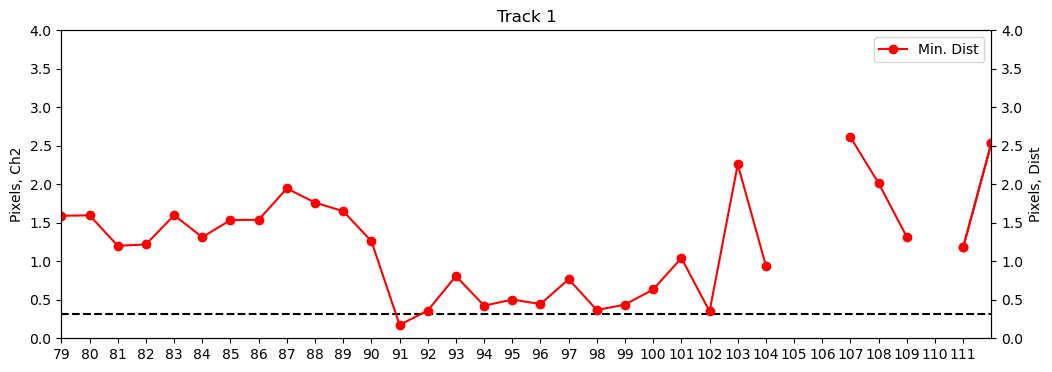

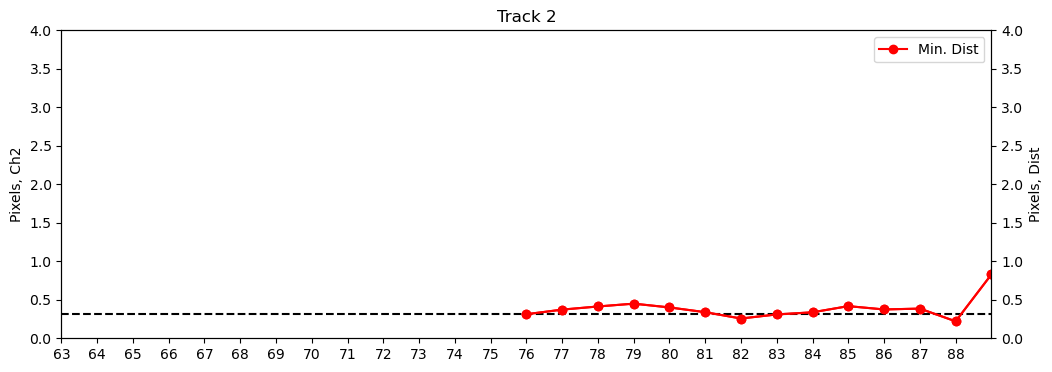

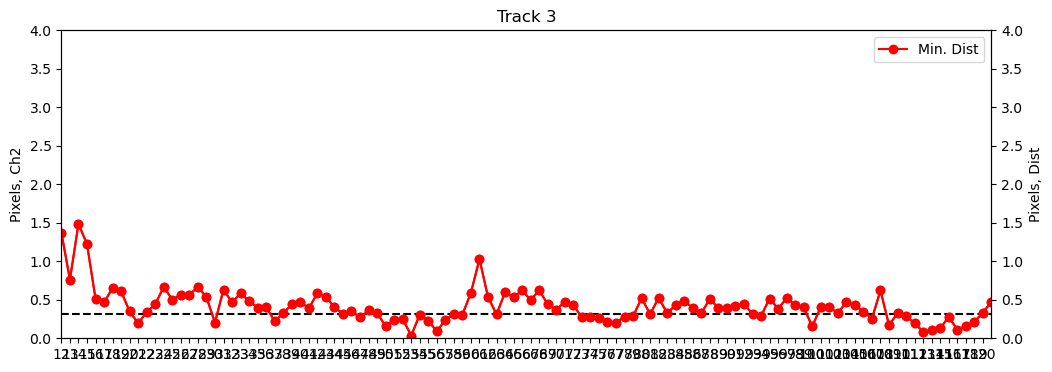

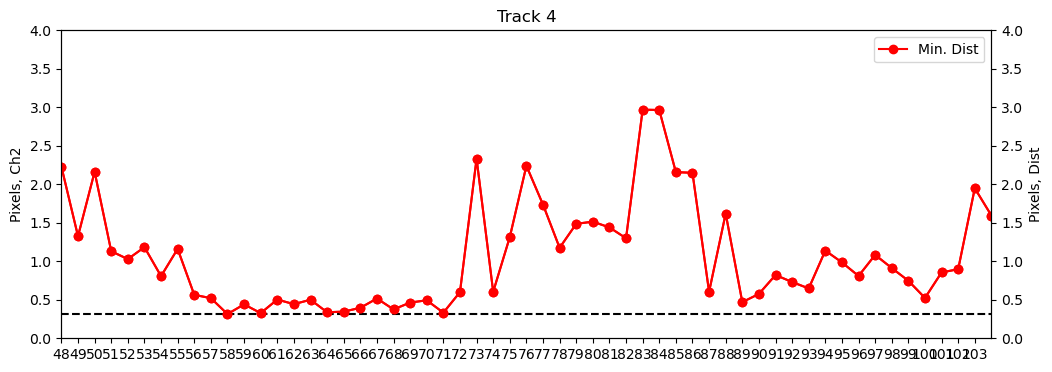

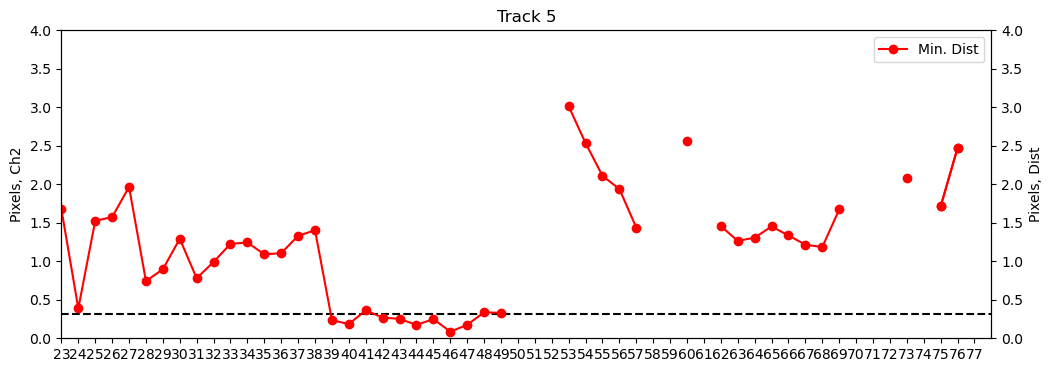

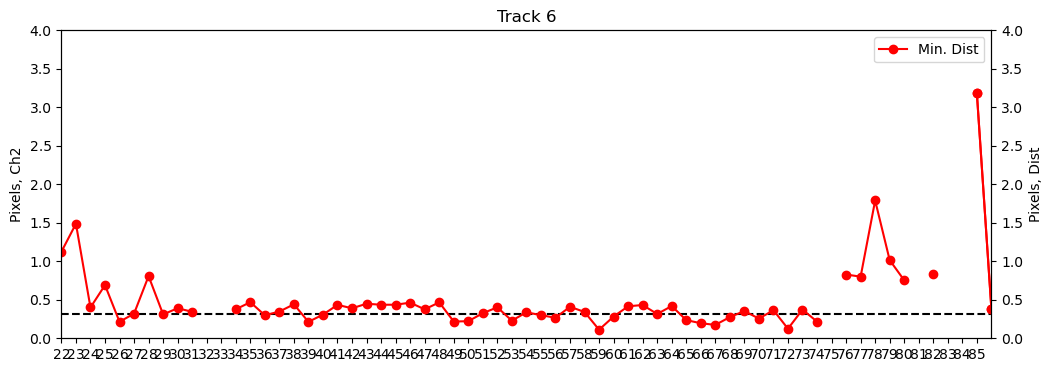

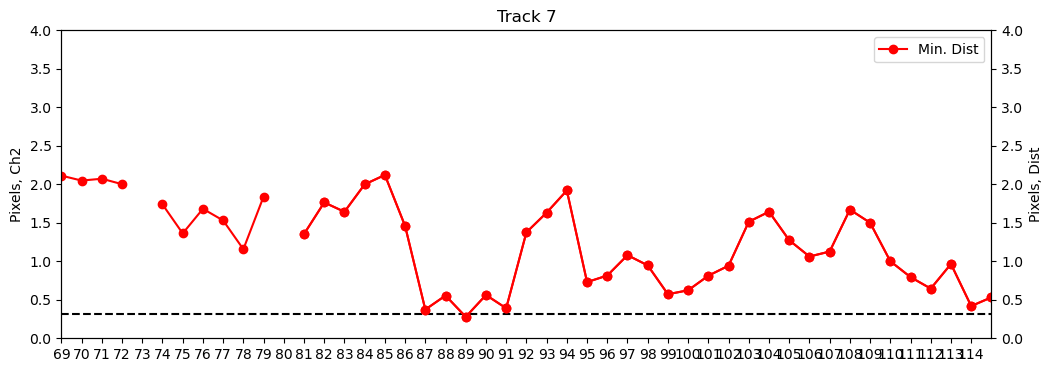

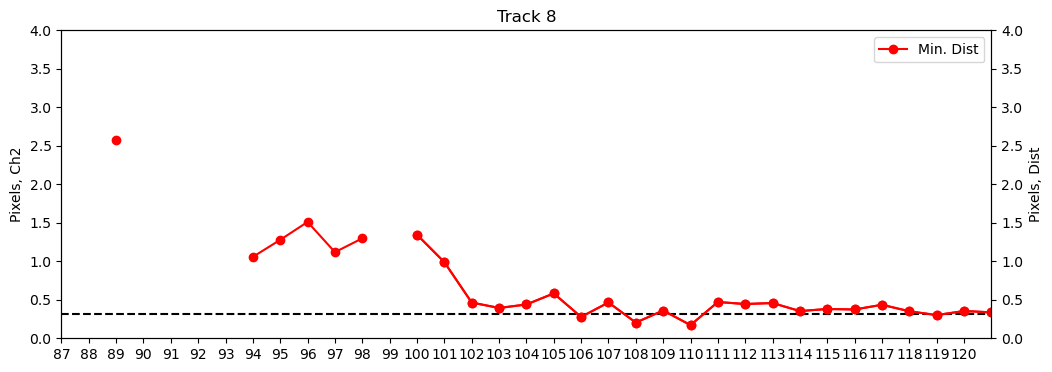

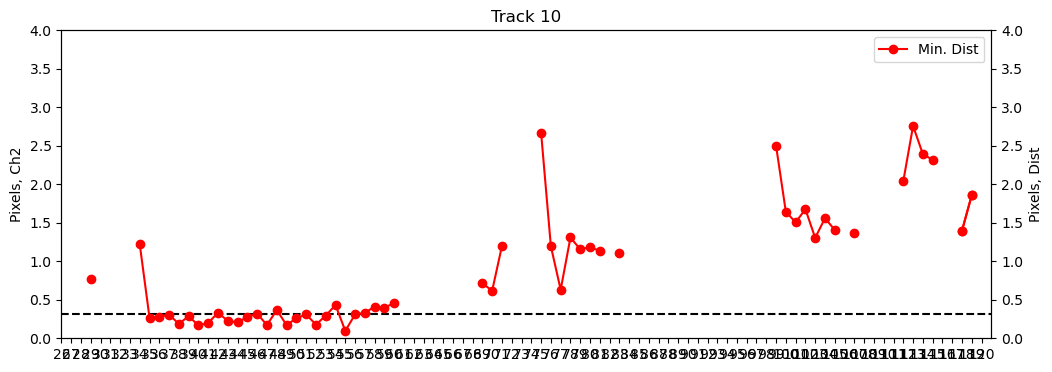

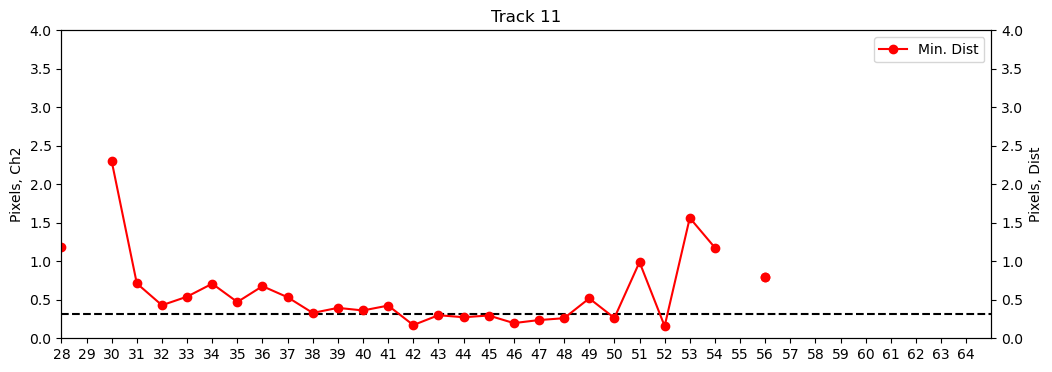

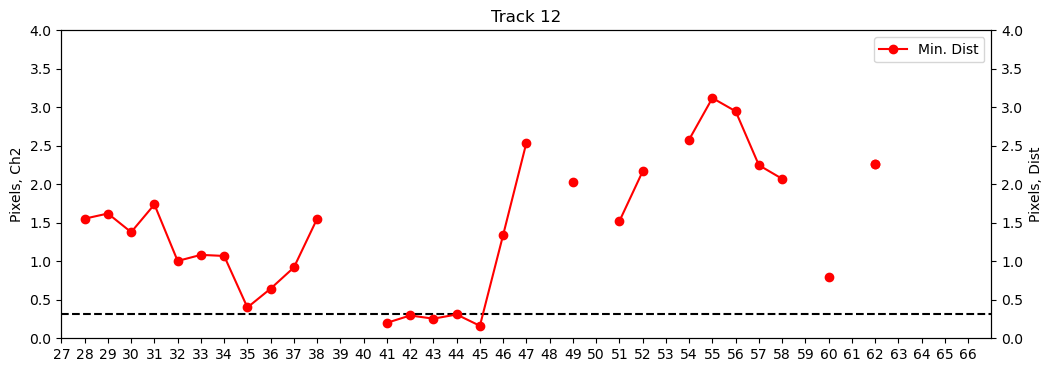

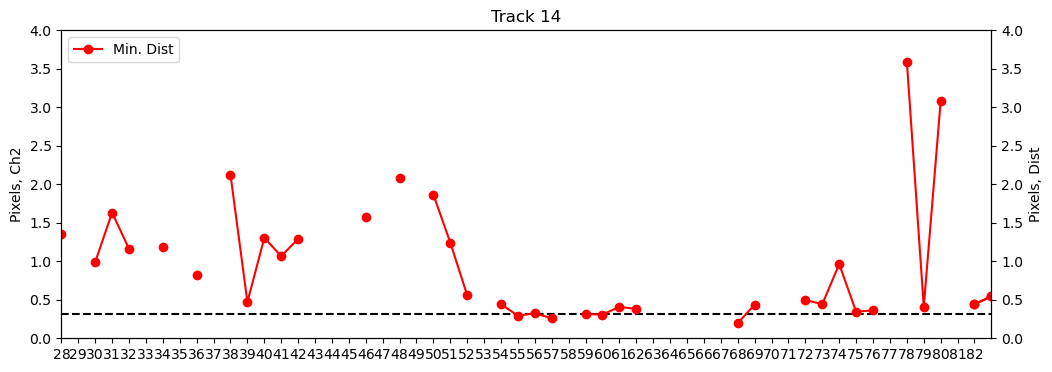

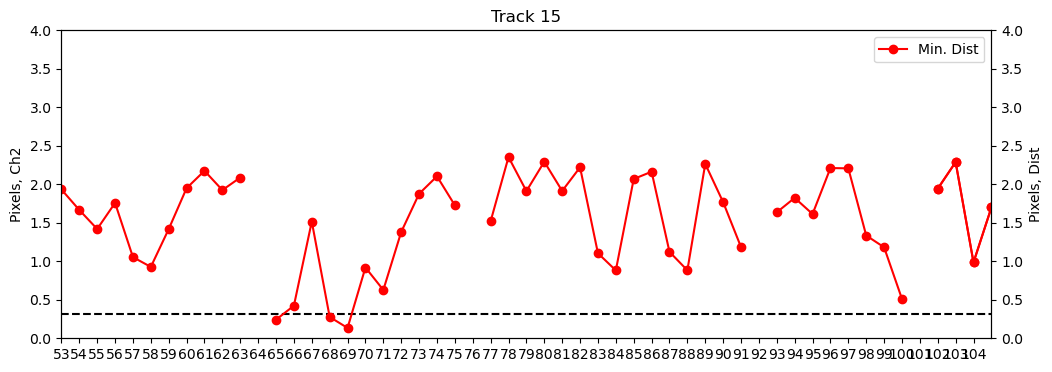

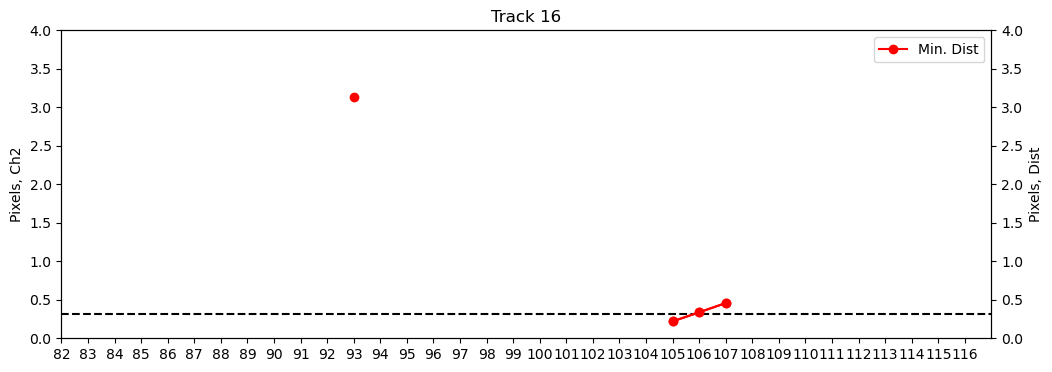

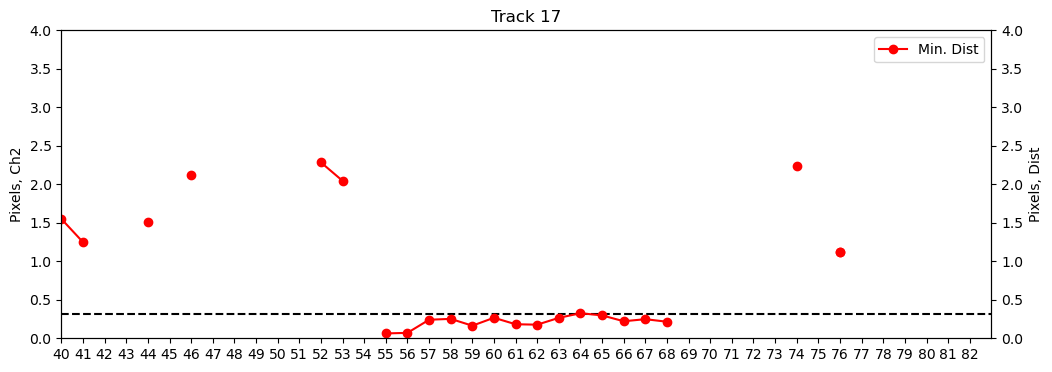

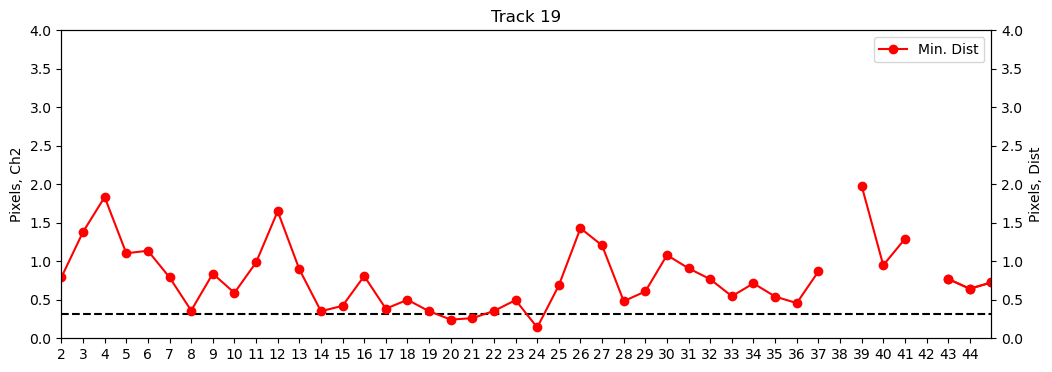

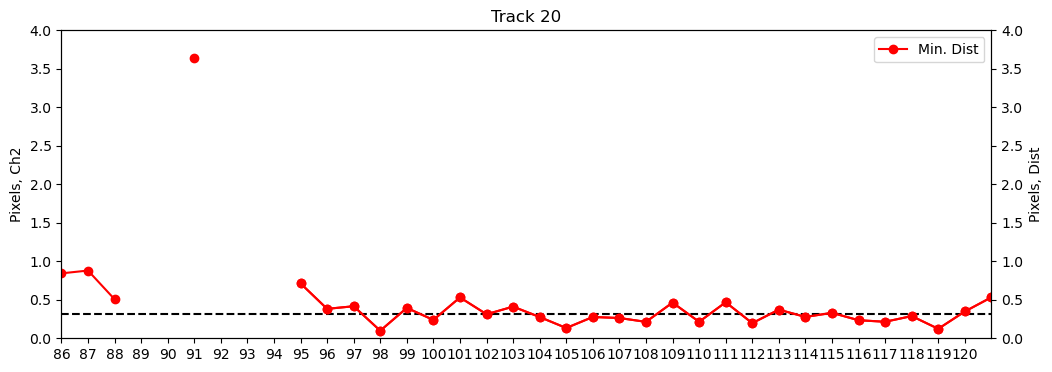

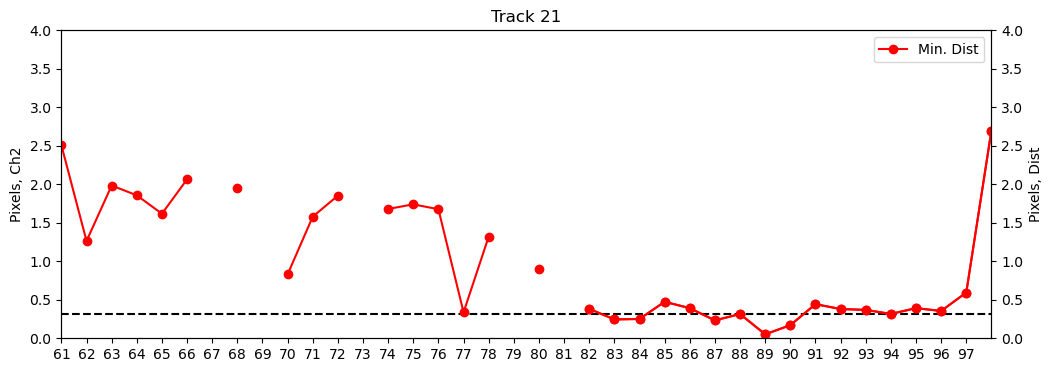

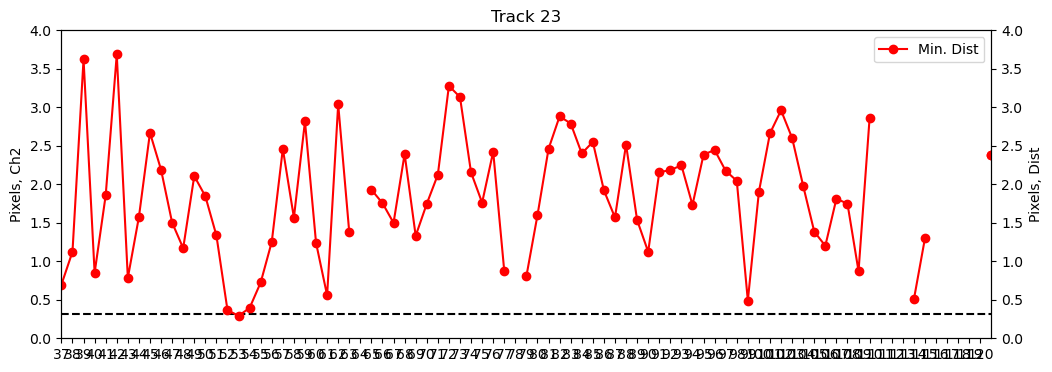

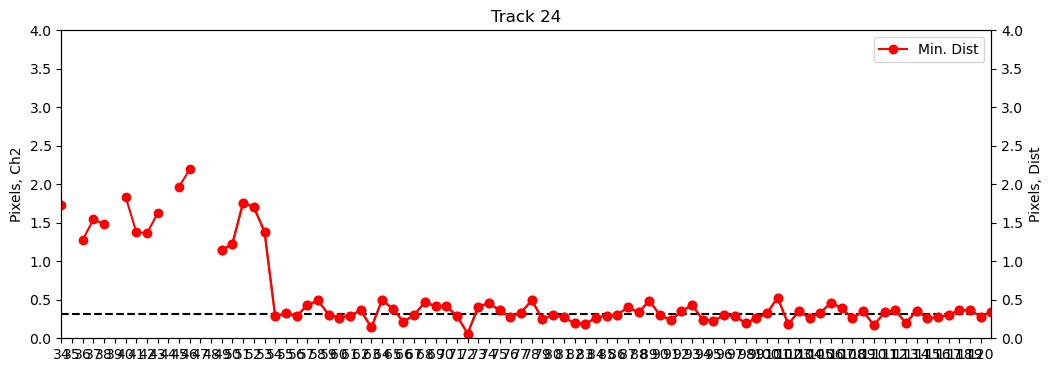

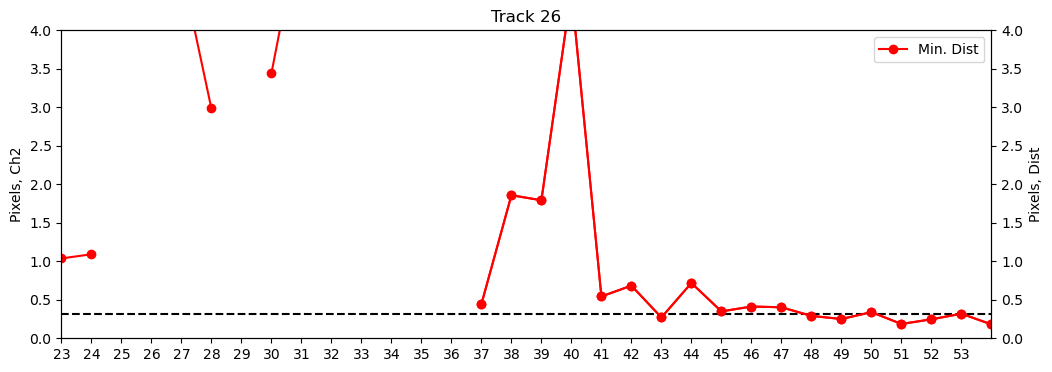

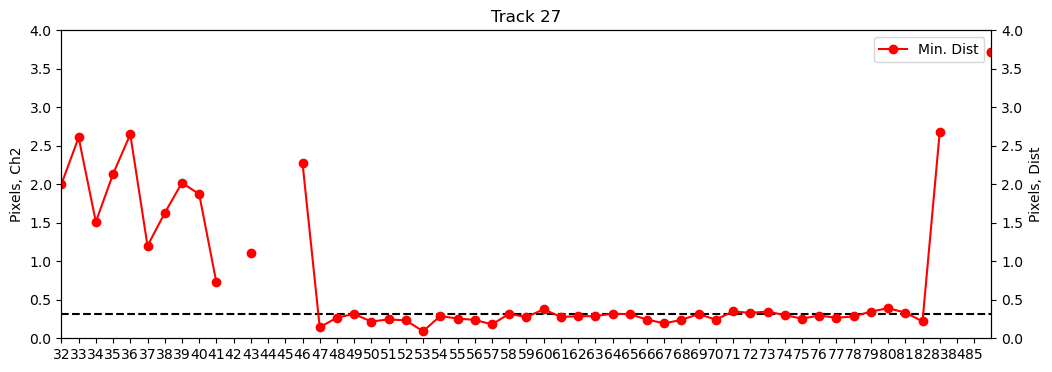

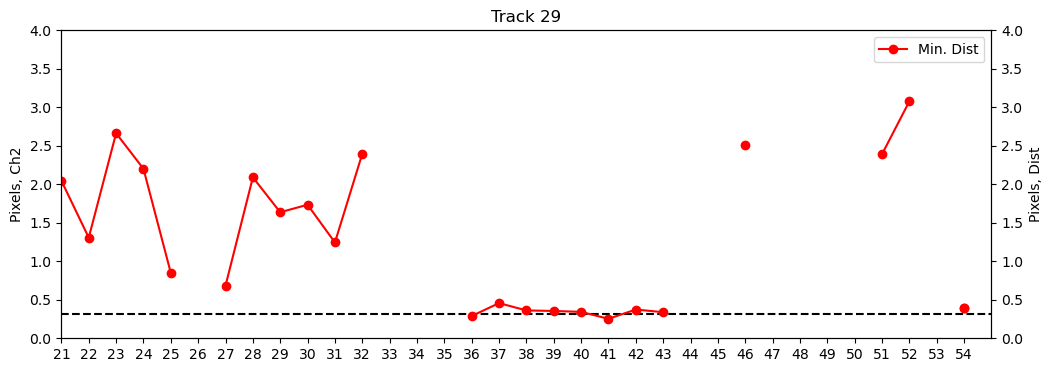

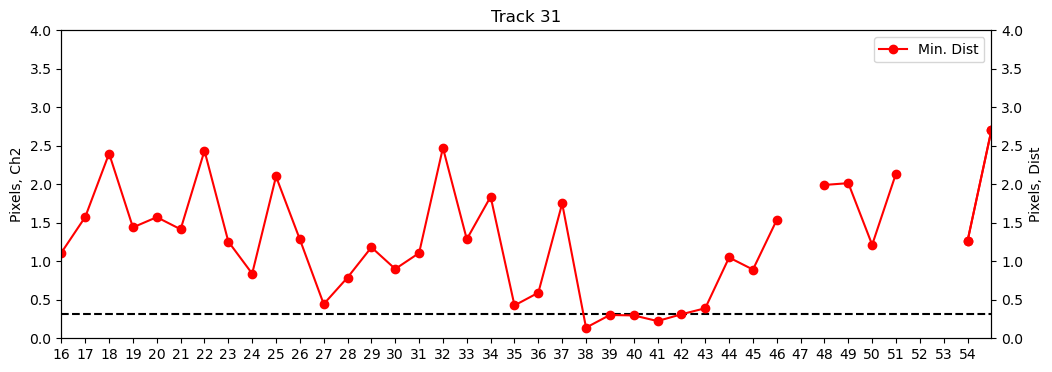

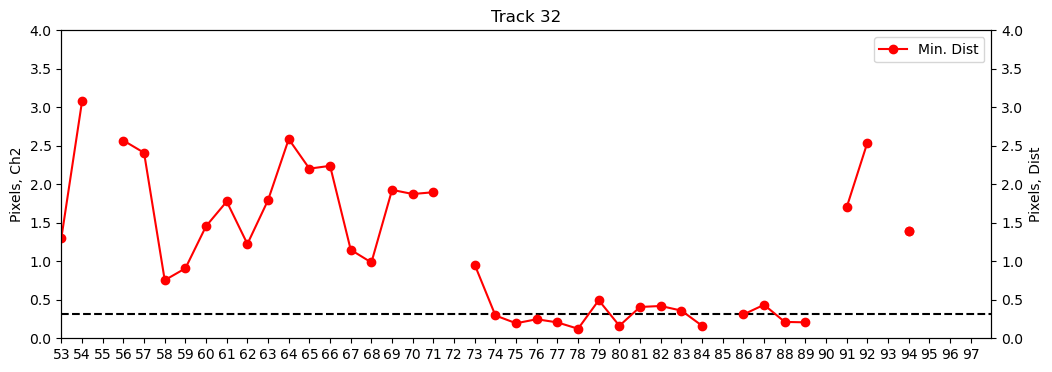

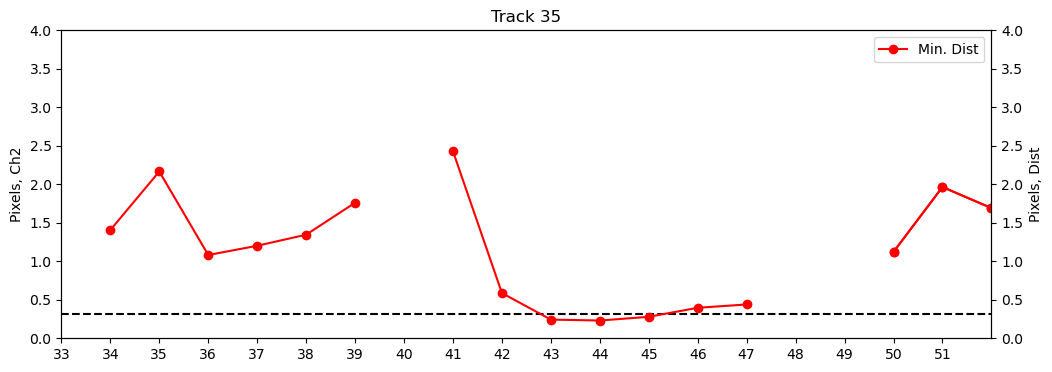

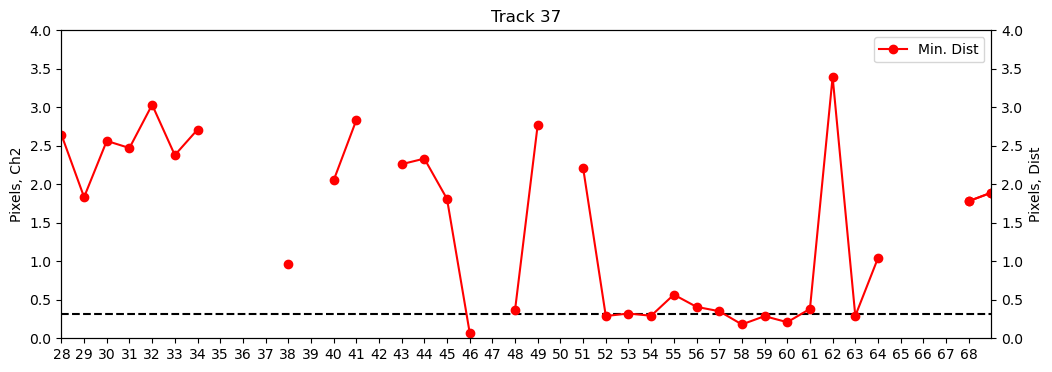

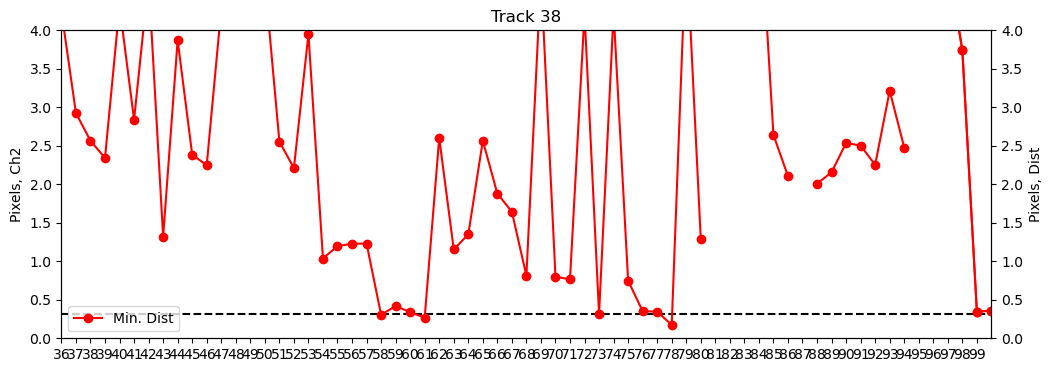

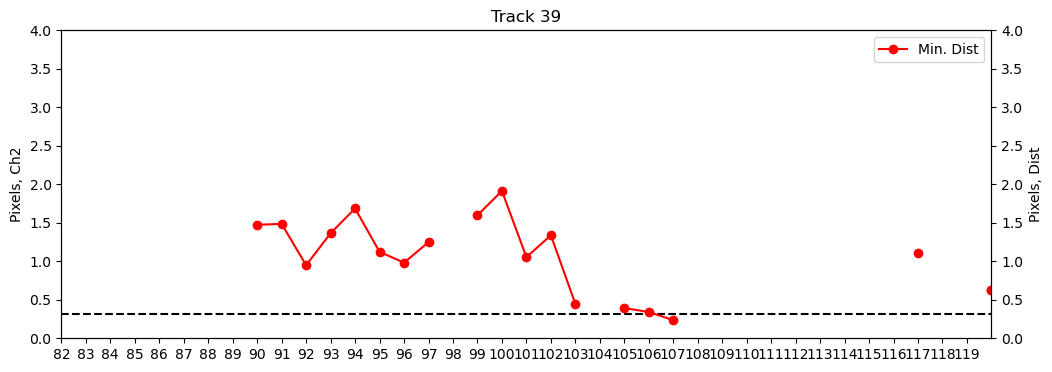

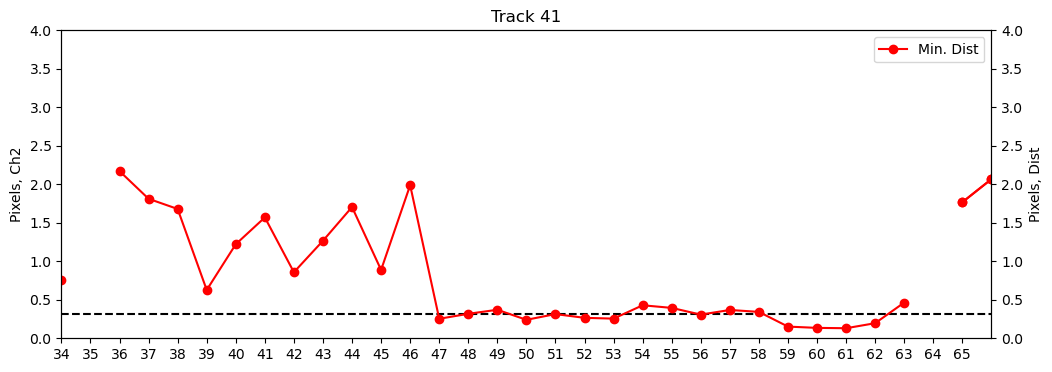

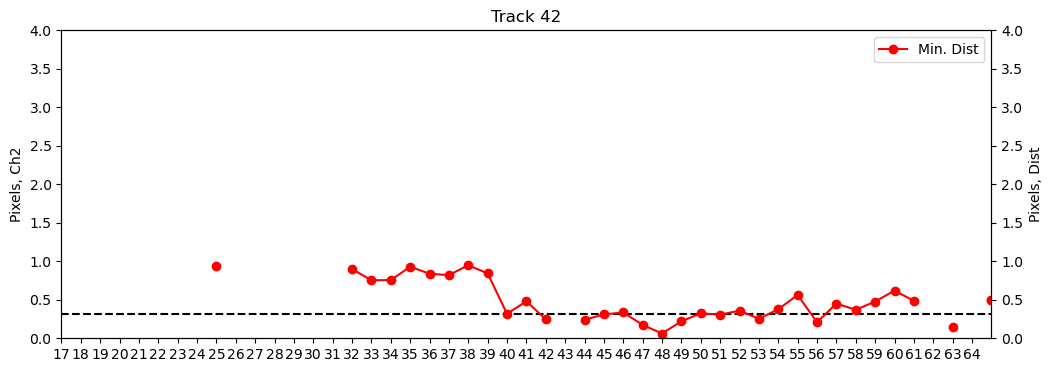

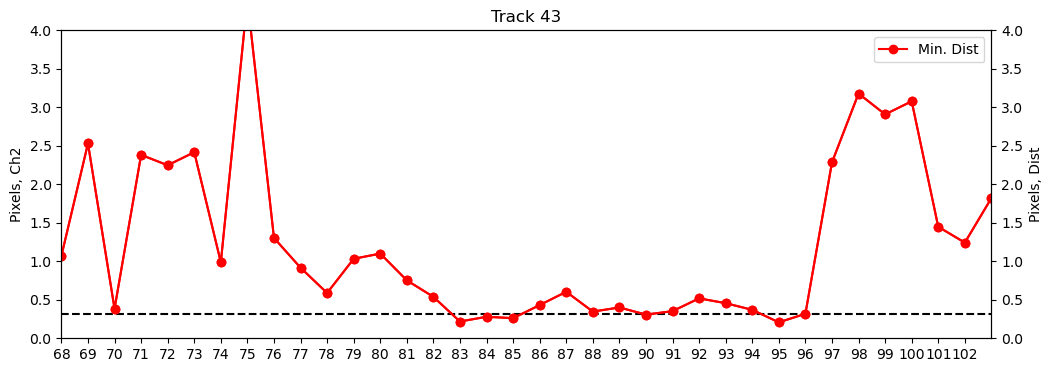

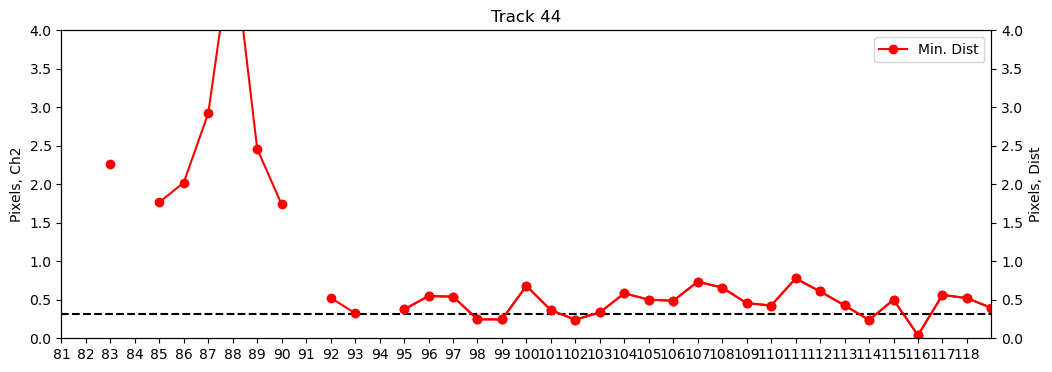

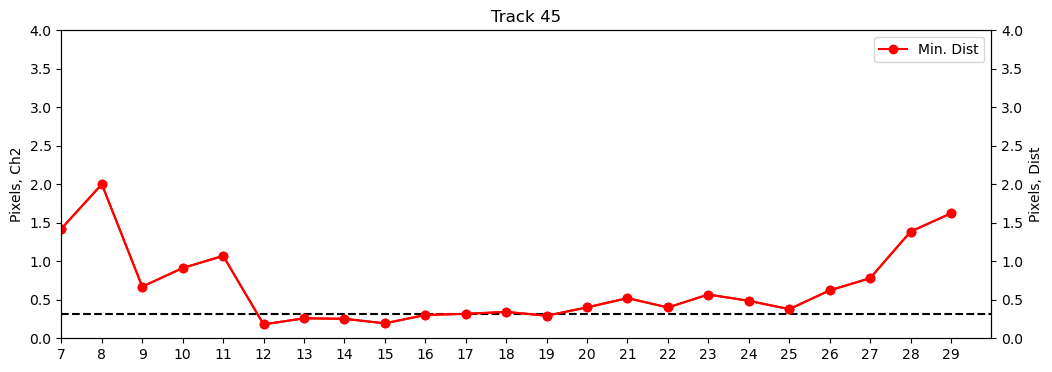

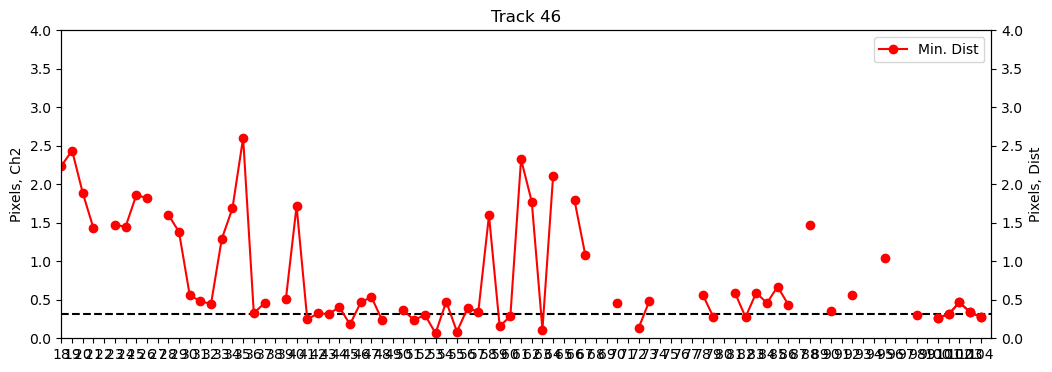

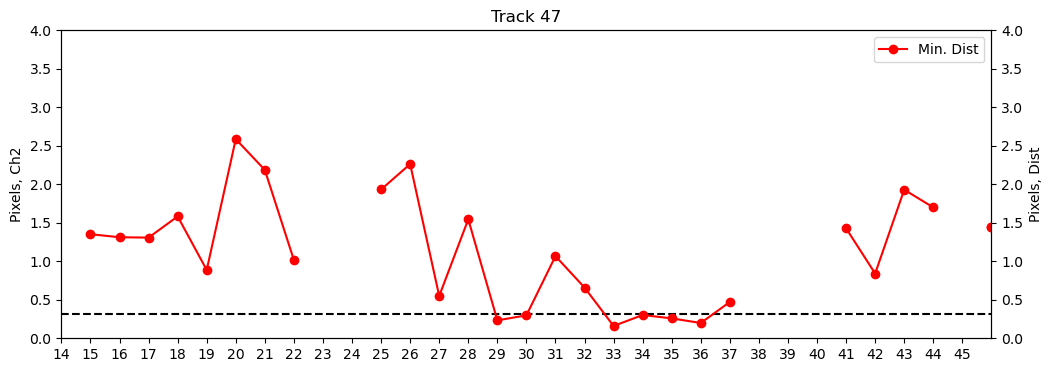

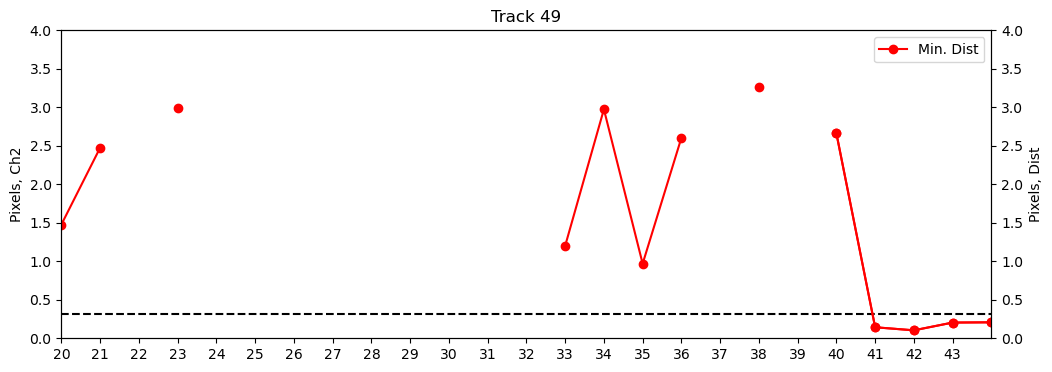

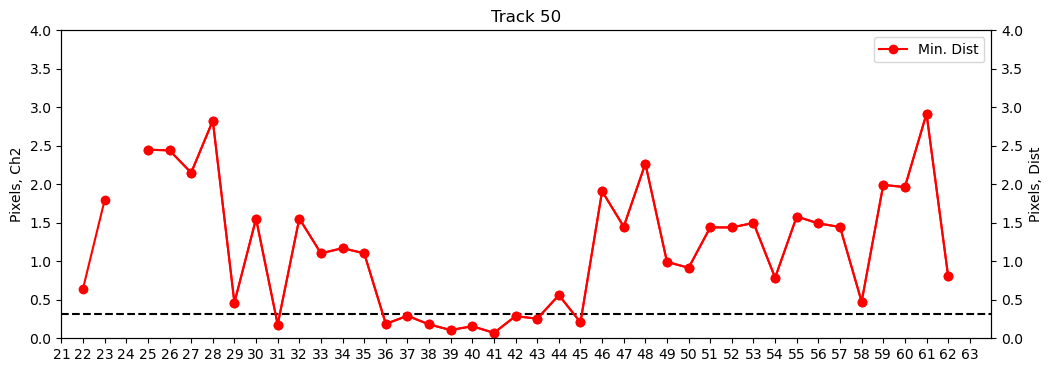

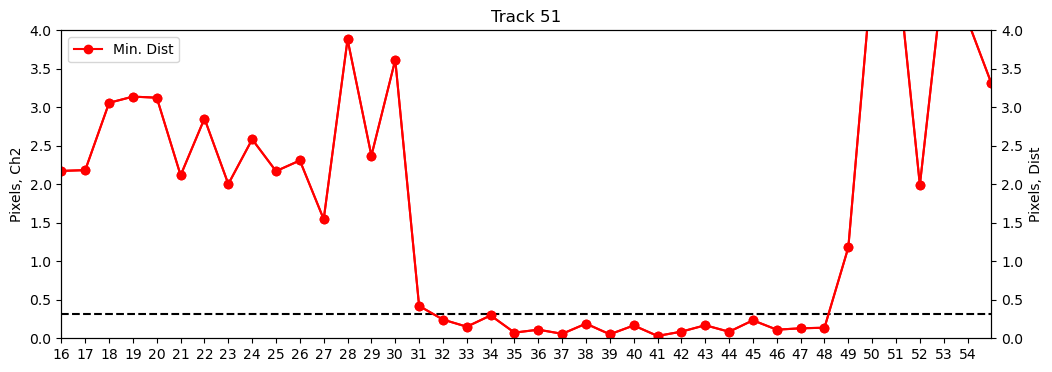

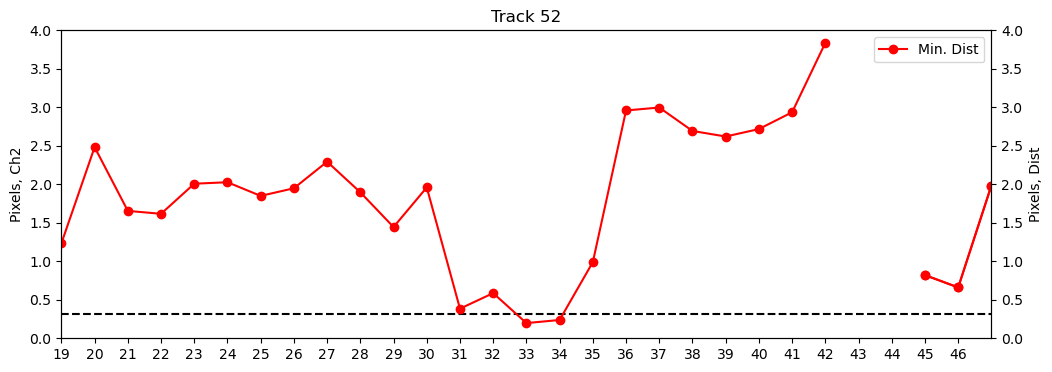

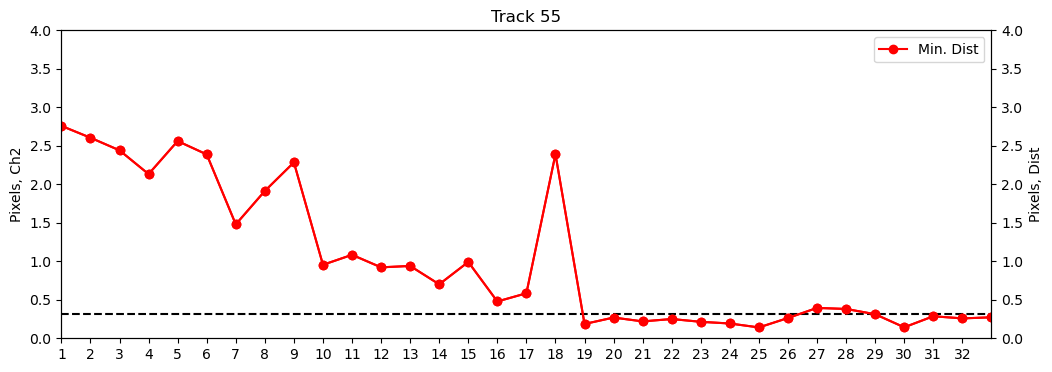

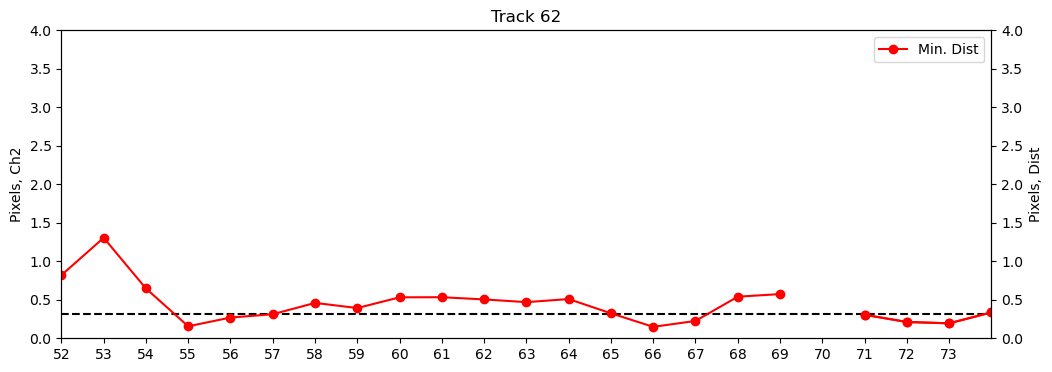

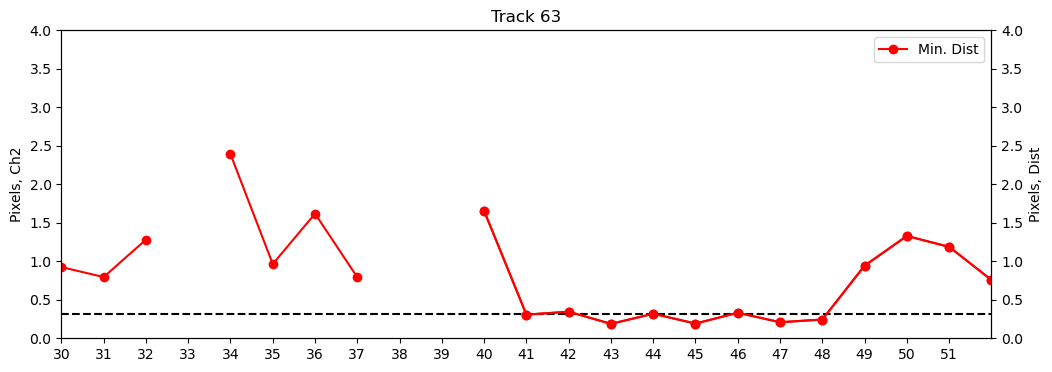

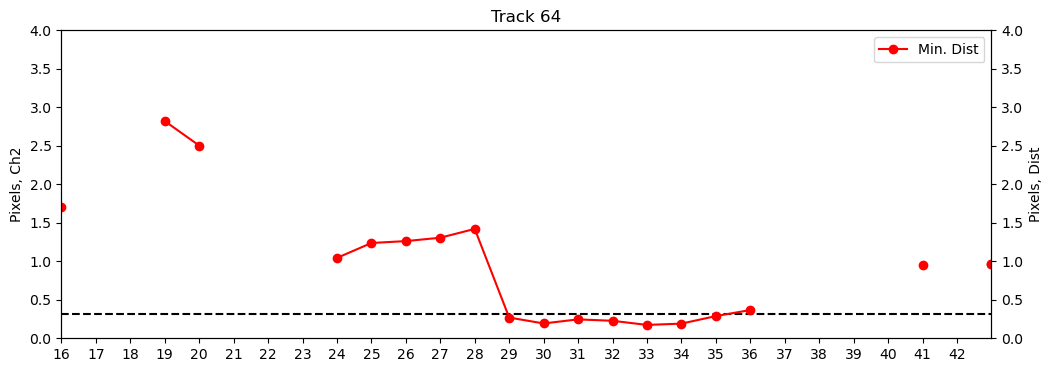

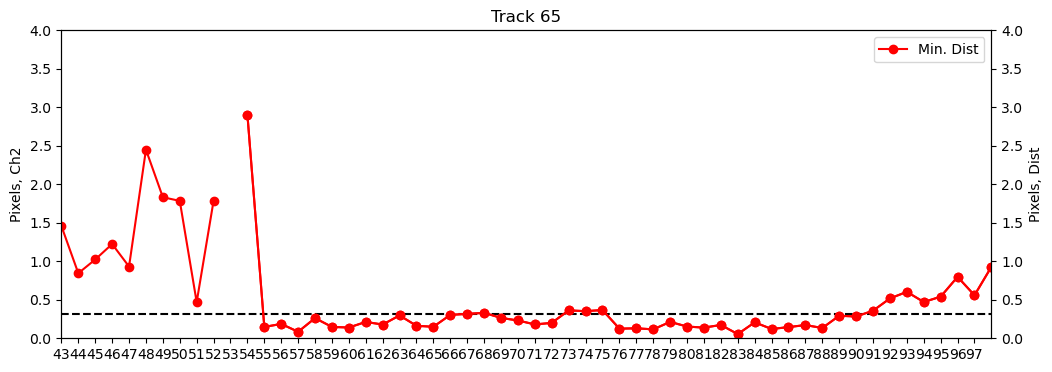

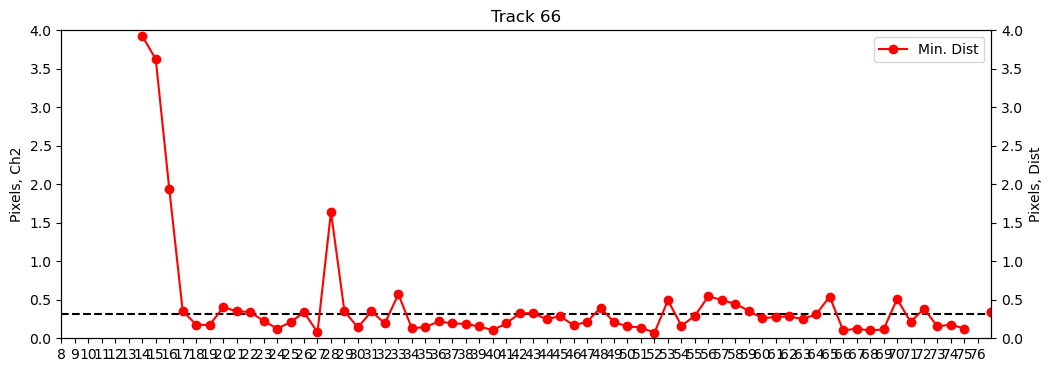

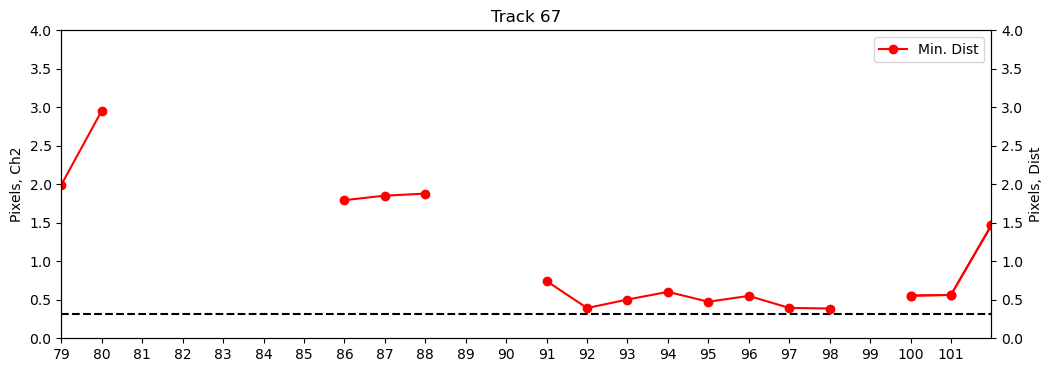

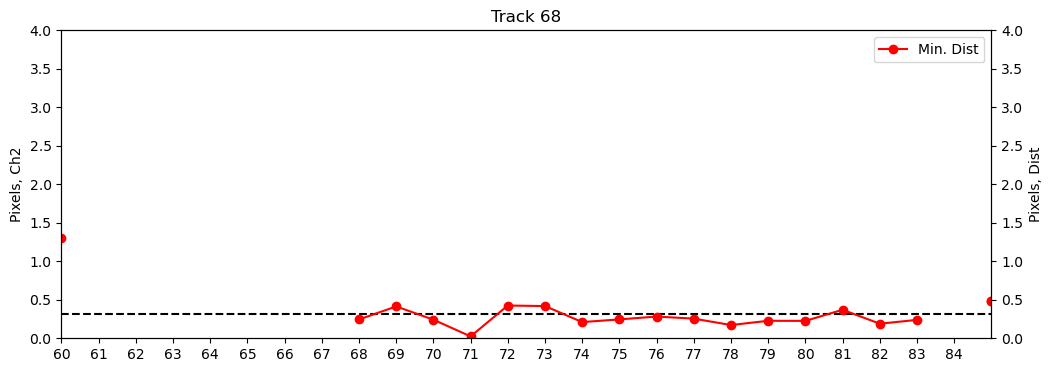

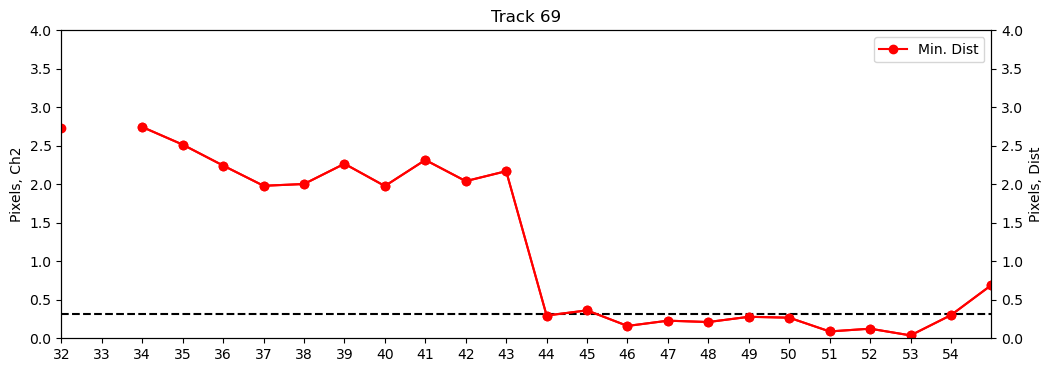

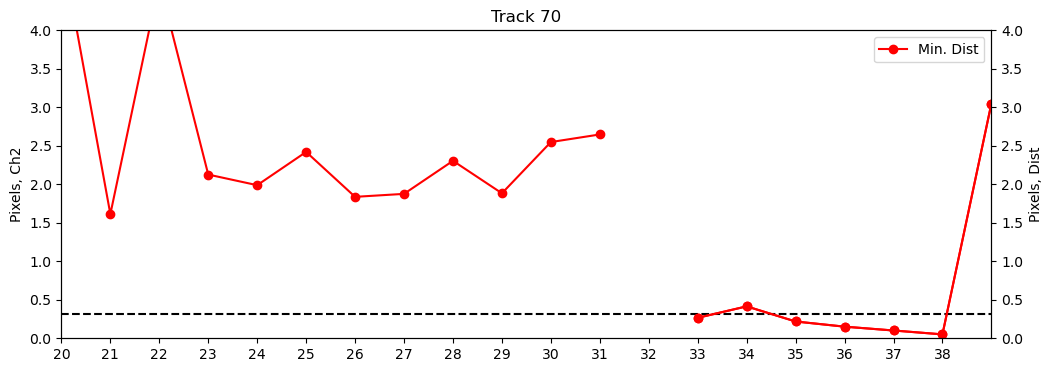

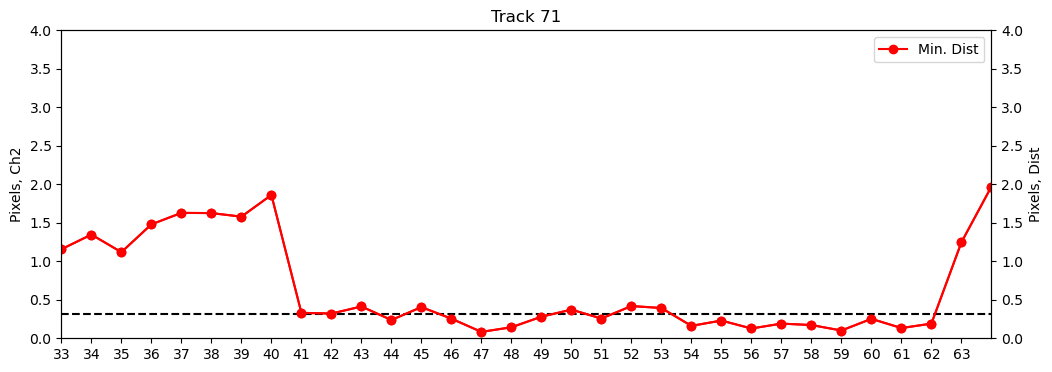

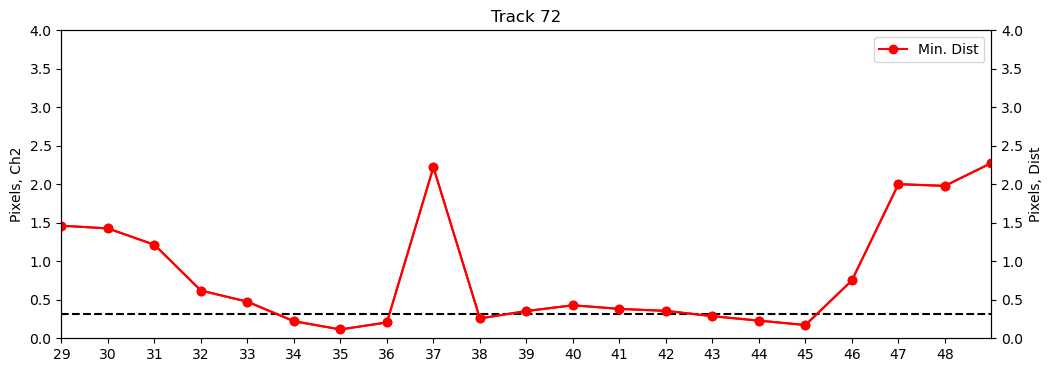

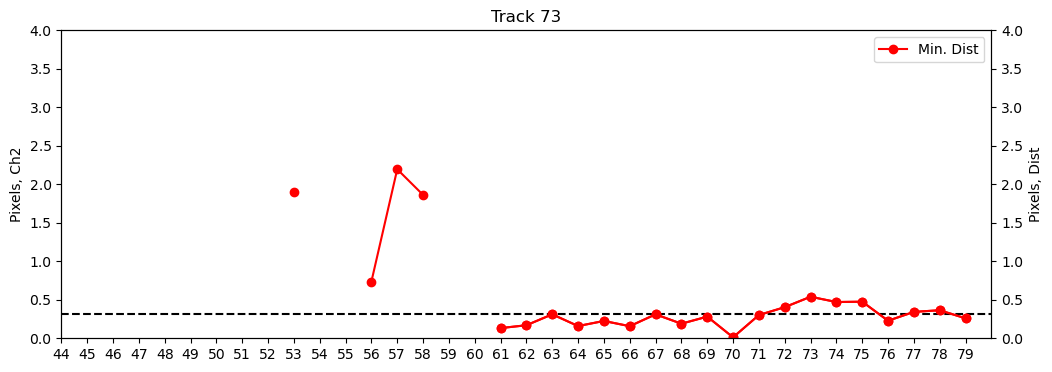

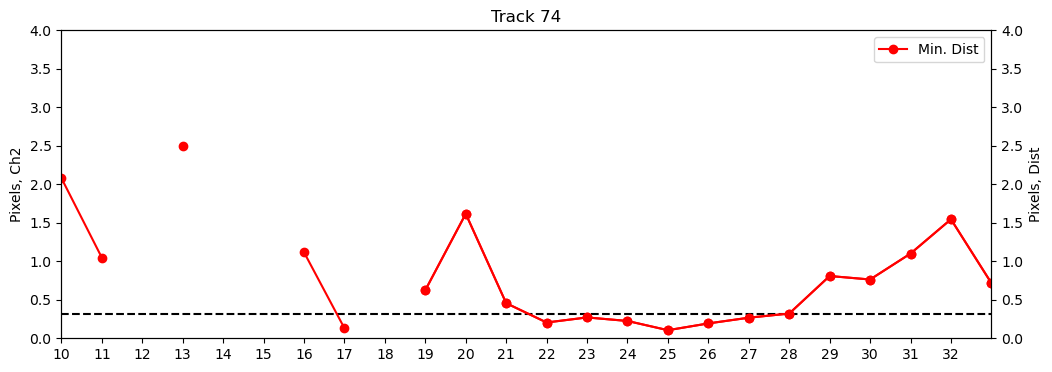

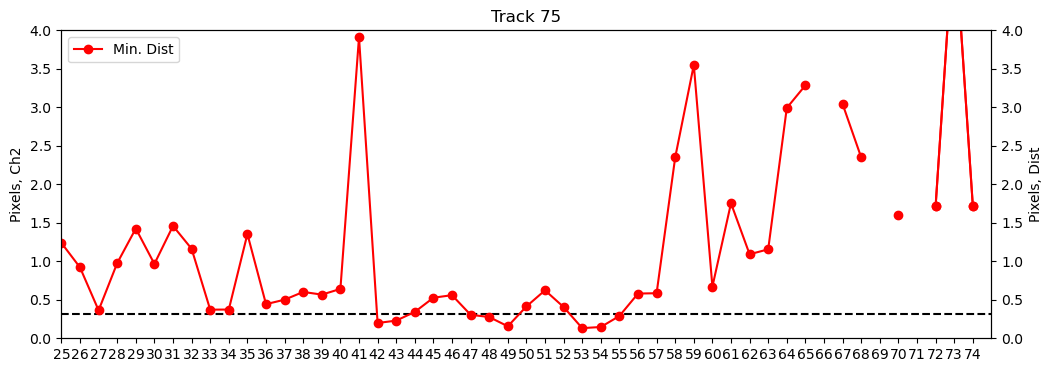

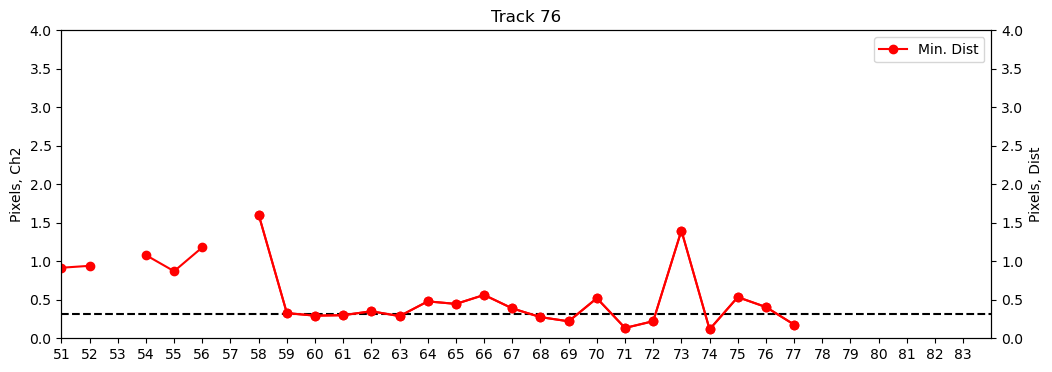

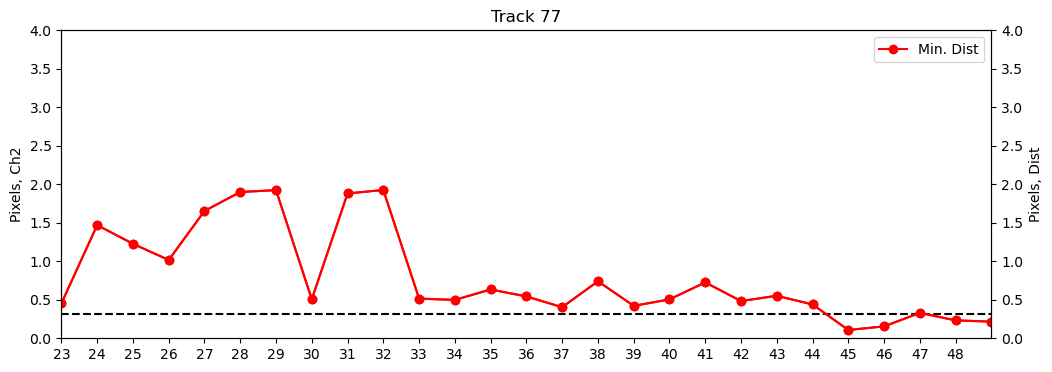

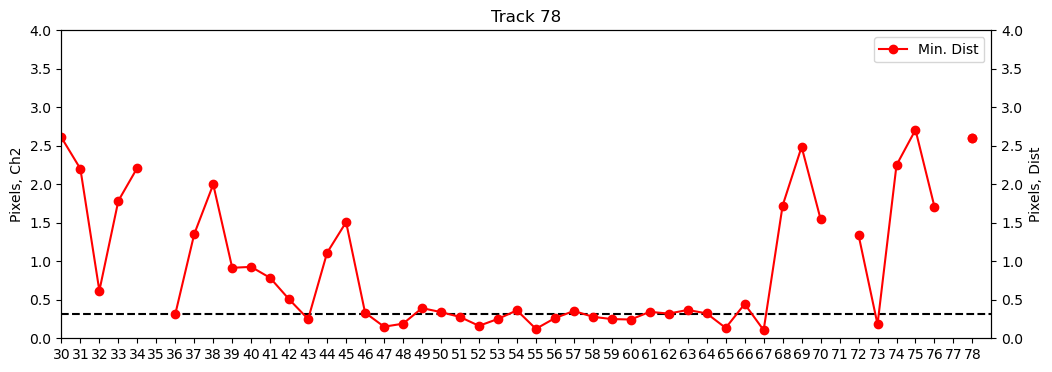

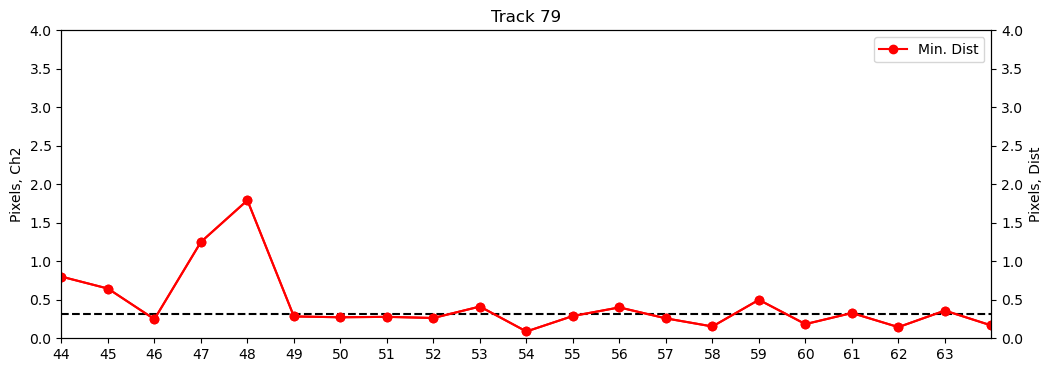

In [64]:
# Driver: 

d = create_dictionary(l_path, f_path)
d = modify_dictionary_metrics(d, std_pos_param)
d = modify_dictionary_distance(d)
#d = modify_dictionary_ball(d, rad_window, shell, first_frame)
d = modify_dictionary_marker(d, dist_cut)

## Saving Data ##

#coloc_df = save_colocalization_list(d, coloc_list_path2, True)
#cat_df = save_all_tracks(d, output_excel_path2)

#################

tracks_w_coloc_events, colocalization_frames, tracks_wo_coloc_events, \
all_events, longest_coloc_events = plot_distances(d, 4, True)

#coloc_matrix, c_idx = get_coloc_matrix(longest_coloc_events, dist_cut)

#mean_val, min_range, max_range, std_val, num_spots = get_coloc_stat_lists(coloc_matrix)

#fig = plot_cohort_statistics(mean_val, min_range, max_range, std_val, num_spots, c_idx, typestring, dist_cut, True)

#hist =     plot_histogram(tracks_w_coloc_events, colocalization_frames, tracks_wo_coloc_events, 100)

